In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window

In [2]:
# CCAT-Prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 #deg^2

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

Pei = 5.7e4 #Jy / sr CCAT-prime

In [3]:
log2=14

In [4]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
I_kappa = np.load(Ik_fname)
vb = np.max(np.abs(I_kappa))

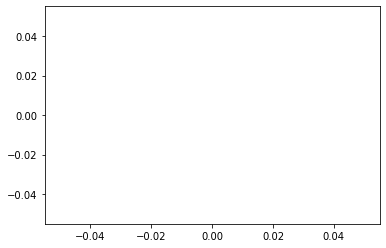

In [5]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11"
})

In [6]:
Lambdas[0]

1e-05

In [11]:
Lambdas[6]

0.0001

In [12]:
Lambdas[12]

0.001

In [13]:
Lambdas[18]

0.01

In [14]:
Lambdas[24]

0.1

/tmp/ipykernel_27425/676494168.py:23: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig('figures/002.012.IHikappa-CCAT-prime-Lambda-%.1e.pdf'%(Lambda), bbox_inches = 'tight')


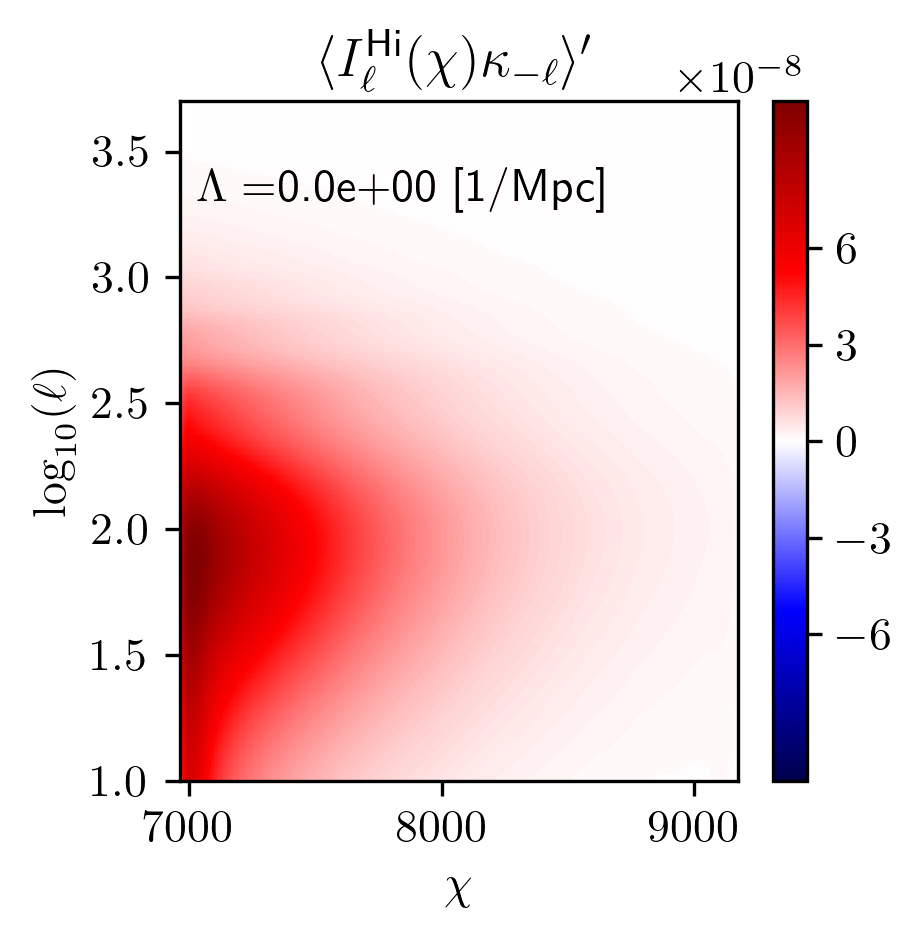

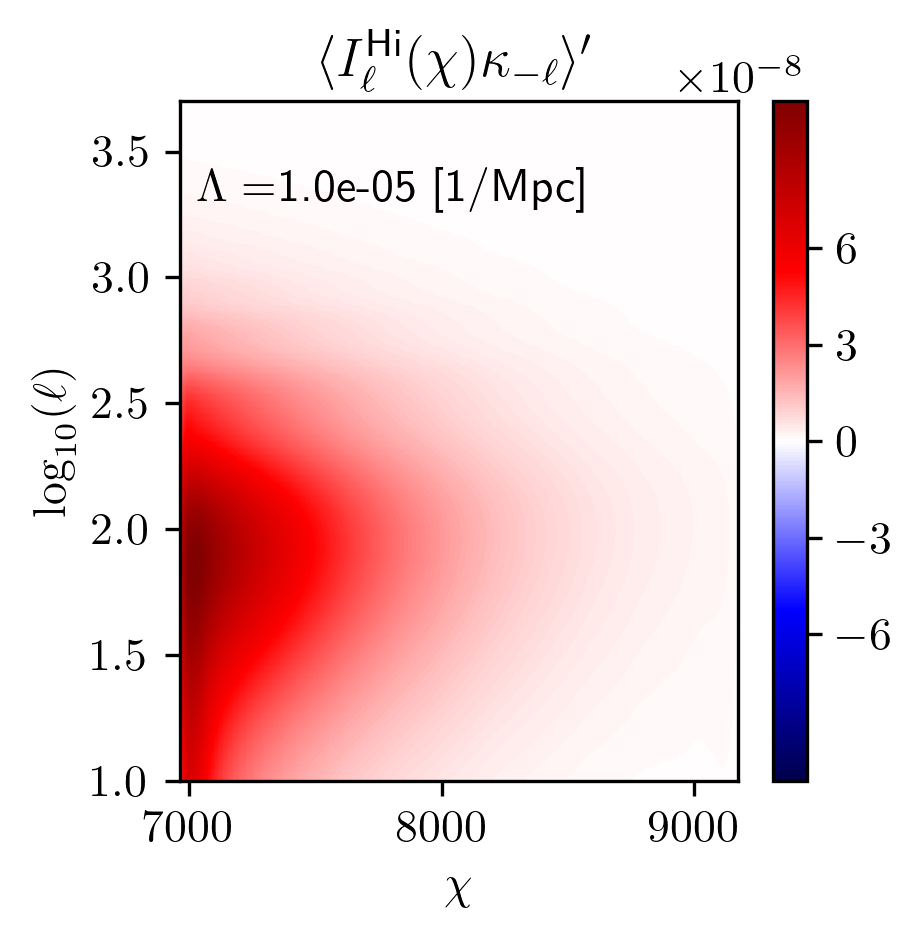

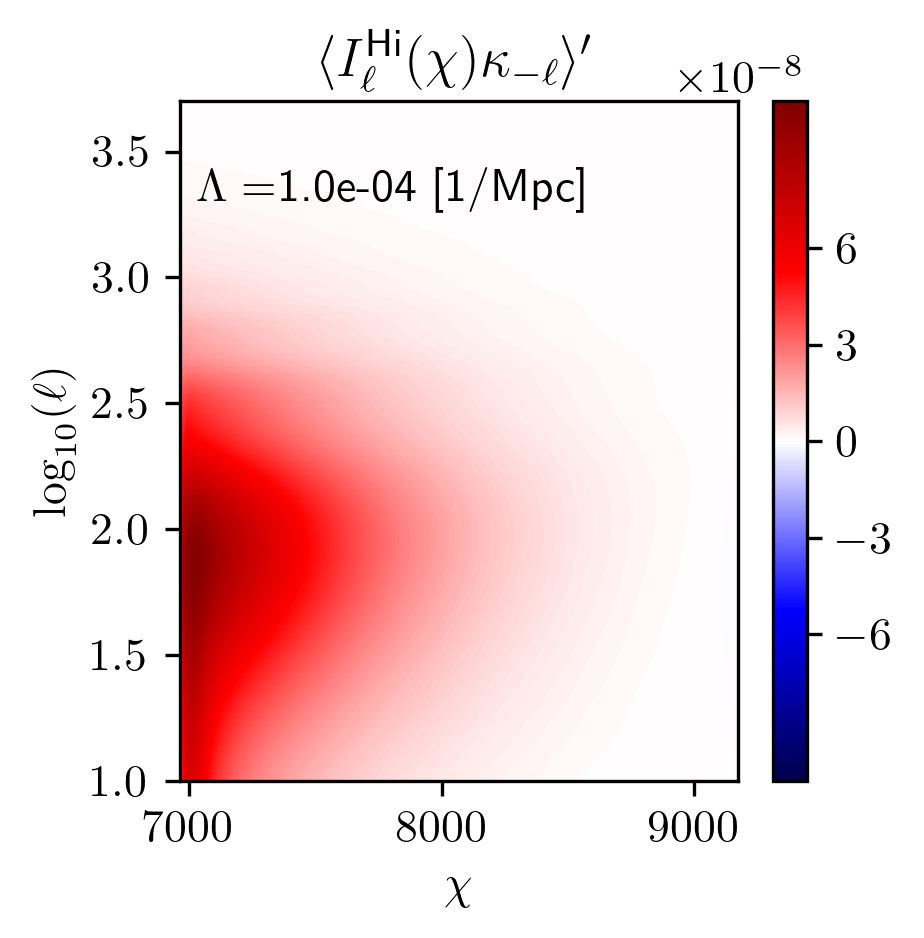

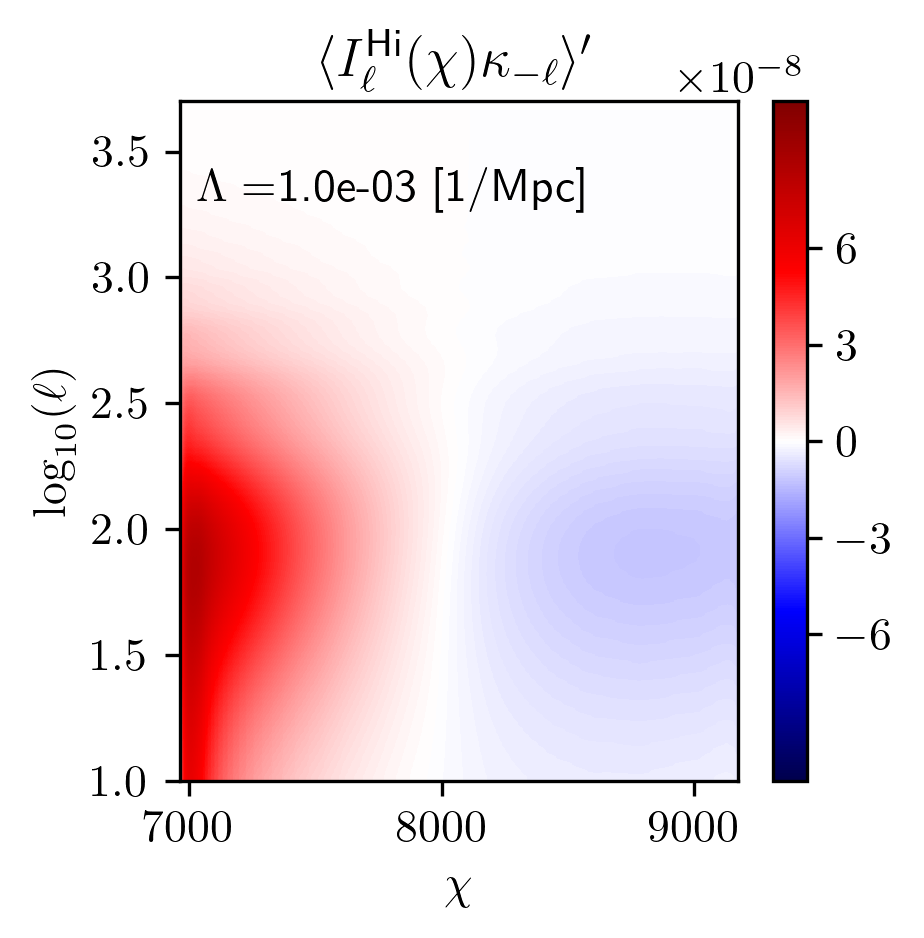

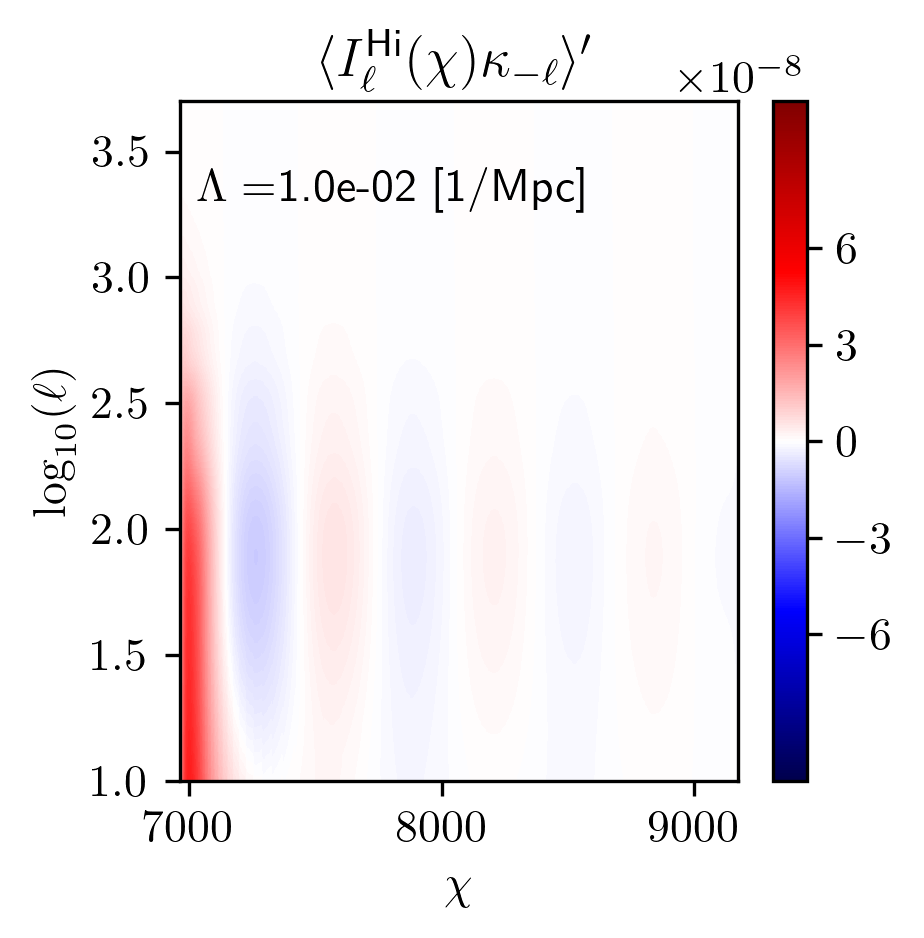

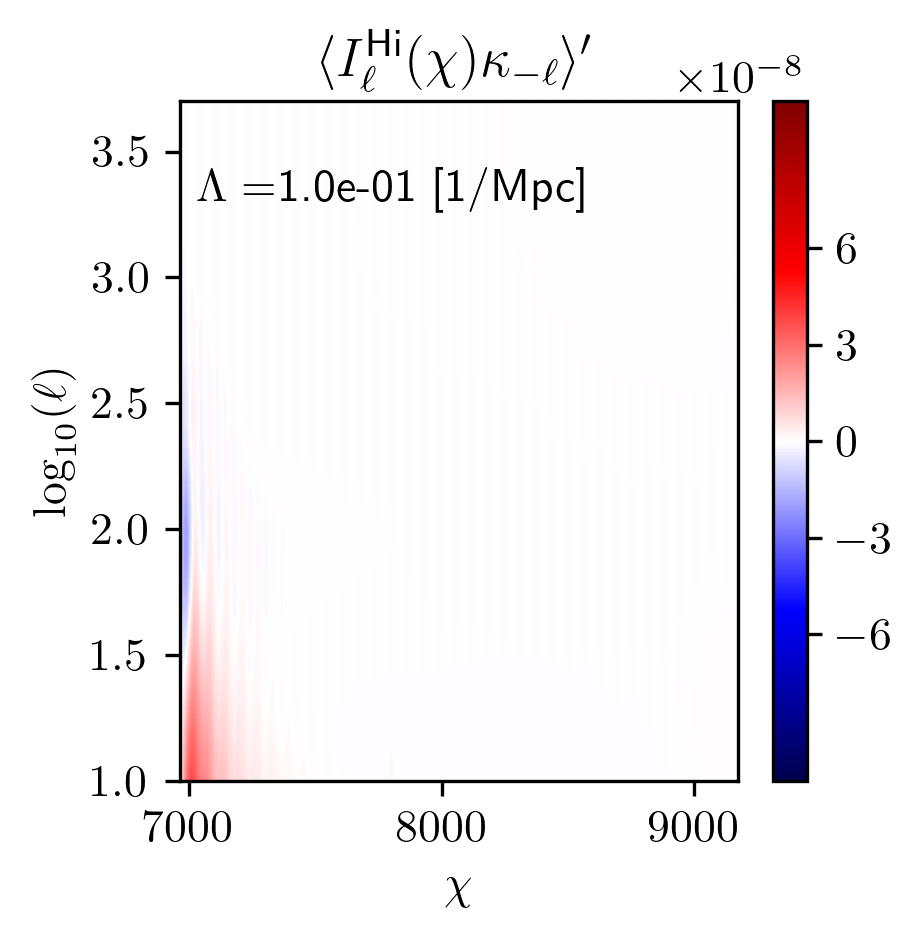

In [25]:
def plot(IHi_kappa, Lambda):
    plt.figure(figsize=(3,3), dpi=300, facecolor='w',)
    log_ymin = np.log10(ells[0])
    log_ymax = np.log10(ells[-1])
    # plot data
    im = plt.imshow(IHi_kappa, 
               origin='lower',
              cmap = 'seismic',
              vmin = -vminmax,
              vmax =  vminmax,
               aspect = 'auto',
              extent=[chimin, chimax, log_ymin, log_ymax])

    cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])
#     cbar.ax.set_ylabel('Linear Scale')


    # set bounds
    plt.title(r"$\langle I_{ \ell}^{\sf Hi}(\chi) \kappa_{- \ell}\rangle'$")
    plt.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))
    plt.xlabel(r'$\chi$')
    plt.ylabel(r"$\log_{10}(\ell)$")
    plt.savefig('figures/002.012.IHikappa-CCAT-prime-Lambda-%.1e.pdf'%(Lambda), bbox_inches = 'tight')

    
    
plot(I_kappa, Lambda=0)
for Lambda in [Lambdas[0],Lambdas[6],Lambdas[12], Lambdas[18], Lambdas[24]]:
    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa
    
    vminmax = vb
    plot(IHi_kappa, Lambda=Lambda)